<a href="https://colab.research.google.com/github/musicjae/Hands_on_ML/blob/master/(2)_ML_project_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving cal_housing.domain to cal_housing.domain
User uploaded file "cal_housing.domain" with length 237 bytes


#2.2 큰 그림 보기  
  
캘리포니아 인구조사 데이터 이용하여, 캘리포니아 주택 가격 모델 만들기

### 문제 정의  
  
파이프라인: 데이터 처리 component들이 연속되어 있는 것. 
  
> 각 컴포넌트는 독립적.이들 간의 인터페이스는 데이터 저장소 뿐.  
  
우리가 풀 문제는 (1) 예측을 위한 회귀를 사용하니까 지도 학습, (2) 여러 특성을 사용하니까 Multiple Regression, (3) 하나의 값만 예측하니까 Univariate Regression 문제이다.

### 성능 측정 지표 선택  
  
- RMSE 평균 제곱근 오차

In [63]:
import numpy as np


def predicted_fn(h):

    return 2*h+3


x = [1,2,3]
y=[-100,-200,-300]



for i in range(len(x)):

    z=np.mean((predicted_fn(x[i])-y[i])**2)
    print(i,'th RMSE: ',z)

0 th RMSE:  11025.0
1 th RMSE:  42849.0
2 th RMSE:  95481.0


- MAE 평균 절댓값 오차  
  
이상치로 보이는 경우가 많을 때는 이 MAE도 고려해볼 수 있다.

# 2.3 데이터 로드  


### 데이터 불러오기

In [64]:
import pandas as pd

cal_housing_data = pd.read_csv('cal_housing.data')
cal_housing_data.shape

(20639, 9)

In [65]:
cal_housing_data.head()

,-122.230000,37.880000,41.000000,880.000000,129.000000,322.000000,126.000000,8.325200,452600.000000
0,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
1,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
2,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
3,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
4,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0


In [66]:
cal_housing_data.rename(columns={'-122.230000':'longitude',
                                 '37.880000':'latitude',
                                 '41.000000':'housing_median_age',
                                 '880.000000':'total_rooms',
                                 '129.000000':'total_bedrooms',
                                 '322.000000':'population',
                                 '126.000000':'households',
                                 '8.325200':'median_income',
                                 '452600.000000':'median_house_value'},inplace=True)
#,'housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value','ocean_proximity'


In [67]:
cal_housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
1,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
2,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
3,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
4,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0


In [68]:
cal_housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20639 entries, 0 to 20638
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20639 non-null  float64
 1   latitude            20639 non-null  float64
 2   housing_median_age  20639 non-null  float64
 3   total_rooms         20639 non-null  float64
 4   total_bedrooms      20639 non-null  float64
 5   population          20639 non-null  float64
 6   households          20639 non-null  float64
 7   median_income       20639 non-null  float64
 8   median_house_value  20639 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


### 도메인 불러오기

In [69]:
cal_housing_domain = pd.read_csv('cal_housing.domain')
cal_housing_domain.shape

(8, 1)

In [70]:
cal_housing_data.describe() # 숫자형 특성의 요약정보

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000
mean,-119.569576,35.631753,28.638888,2635.848152,537.917825,1425.530210,499.557779,3.870455,206843.910122
std,2.003495,2.135947,12.585568,2181.633870,421.248495,1132.463507,382.330173,1.899615,115385.731702
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1448.000000,295.500000,787.000000,280.000000,2.563100,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534700,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.742850,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### 히스토그램 그리기

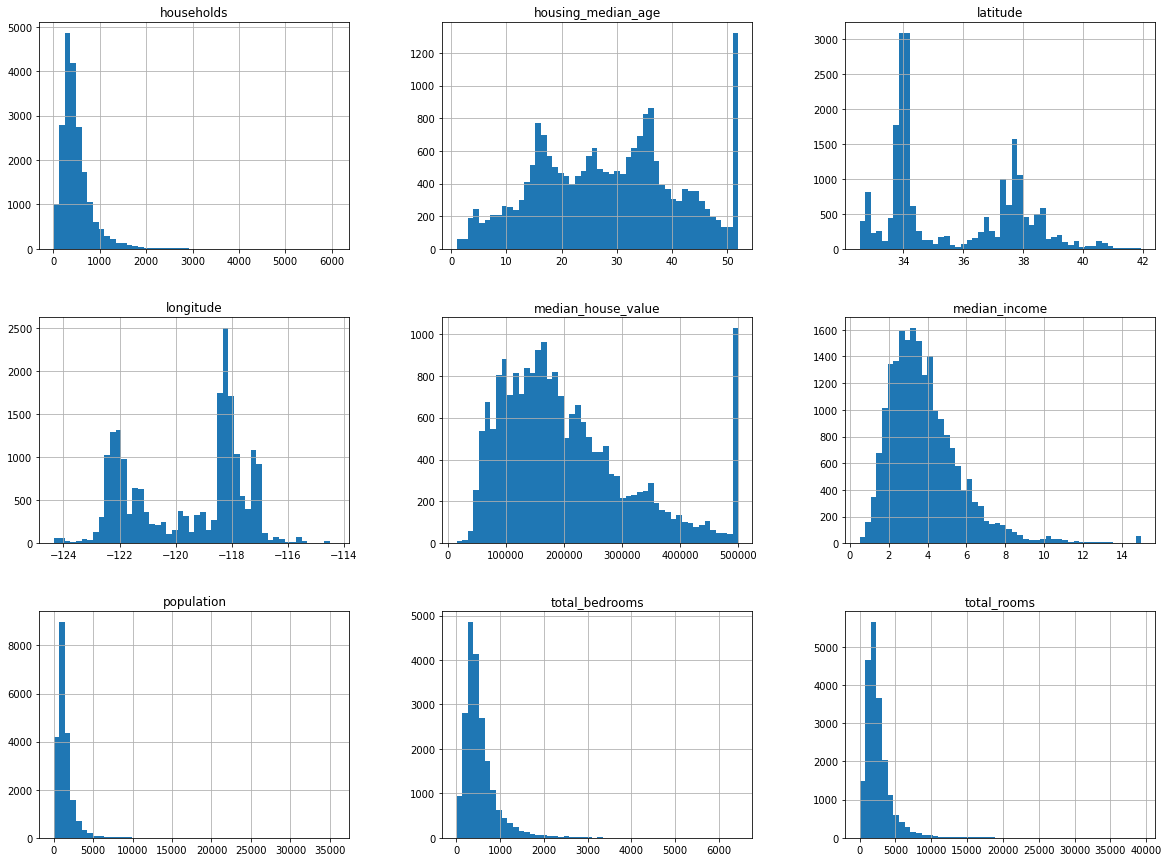

In [71]:
%matplotlib inline
# 맷플롯립이 코랩 자체의 백엔드 사용하게 설정해줘
import matplotlib.pyplot as plt

cal_housing_data.hist(bins=50,figsize=(20,15))
plt.show()

### 테스트 셋 만들기  
  
- Data Snooping Bias: 테스트 셋을 들여다 보면 여기서 겉으로 드러난 어떤 패턴에 속아 특정 ML 모델을 선택하게 될지 모른다. 이걸로 일반화 오차를 추정 시, 너무 낙관적인 추정이 되어, 막상 시스템 론칭 시에 기대한 성능이 안 나올 수 있다.  
  
> 데이터를 본 후에 기계학습 알고리즘을 결정하는 것으로, 사실 데이터를 보기 전에 기계학습 알고리즘을 선정해야 하지만, 현실적으로 현업에서 작업하는 사람들이 흔히 범하는 실수다. 동일한 데이터에 대해 갖가지 기계학습 알고리즘을 적용해서 가장 좋은 성능이 나오는 알고리즘을 선정한다. 문제는 데이터가 바뀌면 어떨까? 아마 기대했던 성능이 나오지 못할 가능성이 크다. https://statkclee.github.io/ml/ml-three-principles.html

#### 1.무작위로 샘플 선택 후 20% 정도를 테스트셋에 두기

In [72]:
import numpy as np

def split_train_test(data, test_ratio):

    shuffled_indices = np.random.permutation(len(data)) # np.random.permutation(9) = [0 6 8 4 1 2 7 3 5]
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(cal_housing_data, 0.2)

print('훈련셋:',train_set[:3], '\n테스트셋: ', test_set[:3])

훈련셋:        longitude  latitude  ...  median_income  median_house_value
2582     -124.09     40.87  ...         1.1576             87500.0
16957    -122.31     37.53  ...         5.9539            379100.0
13132    -121.42     38.47  ...         2.3343             97800.0

[3 rows x 9 columns] 
테스트셋:         longitude  latitude  ...  median_income  median_house_value
12323    -116.44     33.93  ...         1.6849             88400.0
9526     -123.16     39.10  ...         2.7750            120800.0
16396    -121.25     38.00  ...         2.8958            135000.0

[3 rows x 9 columns]


위 방법의 문제점:  
  
- 프로그램을 다시 시작할 때 마다 다른 테스트셋이 생성된다. 여러 번 반복 실행하면 우리는 전체 데이터셋을 보는 것과 다름 없다.

#### 2.순수히 무작위적인 샘플링 방식

In [73]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(cal_housing_data, test_size = 0.2, random_state = 42)

In [74]:
print(train_set.shape, test_set.shape)
print(train_set[:3])

(16511, 9) (4128, 9)
       longitude  latitude  ...  median_income  median_house_value
14195    -117.03     32.71  ...         3.2596            103000.0
8267     -118.17     33.74  ...         3.7838            500001.0
17444    -120.48     34.66  ...         4.1563            172600.0

[3 rows x 9 columns]


위 방식은 데이터셋이 충분히 **클** 때에는 일반적으로 괜찮지만, 그렇지 않은 경우에 **샘플링** **편향**이 생길 가능성이 높다. (가령, 설문조사 때 전화할 샘플 대상들을 연구자들은 무작위로 선정하지 않는다.)  
  
가령, 미국 인구 51.3 %가 여성이고, 48.7 % 가 남성이면, 잘 구성된 설문조사는 **샘플에서도** 이 비율을 **유지해야** 합니다. ===> **계층적** **샘플링** Stratified Sampling  
  
전체 인구의 계층strata은 동질의 그룹으로 나뉘고 테스트셋이 전체 인구를 **대표할** **수** **있도록** 각 계층에서 올바른 수의 샘플을 추출한다. (==> 편향이 위 방법 보다 적다)

#### 3.계층적 샘플링

In [75]:
cal_housing_data["income_cat"] = pd.cut(cal_housing_data["median_income"],
                                        bins = [0,2,4,6,8, np.inf],
                                        labels = [1,2,3,4,5])

In [76]:
print(cal_housing_data["income_cat"])

0        5
1        4
2        3
3        2
4        3
        ..
20634    1
20635    2
20636    1
20637    1
20638    2
Name: income_cat, Length: 20639, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]


AxesSubplot(0.125,0.125;0.775x0.755)


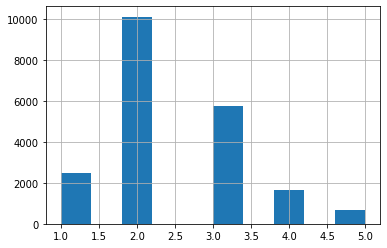

In [77]:
print(cal_housing_data["income_cat"].hist())

### 위에서 구한 소득 카테고리를 기반으로 계층 샘플링 하기

In [86]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits = 1,
    test_size = 0.2,
    random_state = 42
)

for train_index, test_index in split.split(cal_housing_data, cal_housing_data["income_cat"]):

    strat_train_set = cal_housing_data.loc[train_index]
    strat_test_set = cal_housing_data.loc[test_index]

테스트 셋에서 소득 카테고리의 비율

In [87]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

2    0.489099
3    0.277374
1    0.119186
4    0.080911
5    0.033430
Name: income_cat, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


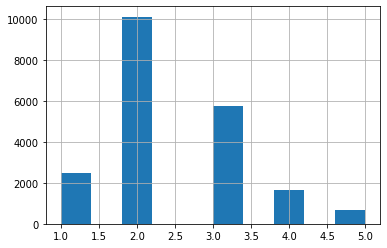

In [84]:
print(cal_housing_data["income_cat"].hist())

이제, income_cat의 특성을 삭제해서 데이터를 원래 상태로 되돌리겠다.

In [88]:
for set_ in (strat_train_set, strat_test_set):

    set_.drop("income_cat", axis=1, inplace= True) # drop 메서드는 "행/열 삭제해" axis=0 -> 행 삭제, 1 -> 열 삭제. 

# 2.4 데이터 이해를 위한 탐색/시각화

In [22]:
cal_housing_data = strat_train_set.copy()

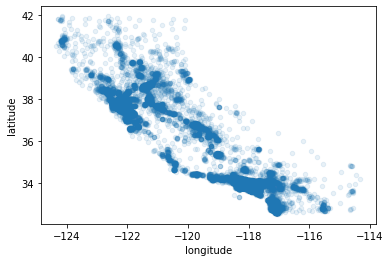

In [89]:
cal_housing_data.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.1) # alpha는 데이터가 밀집된 지역을 잘 보여준다.

### 주택 가격 나타내기

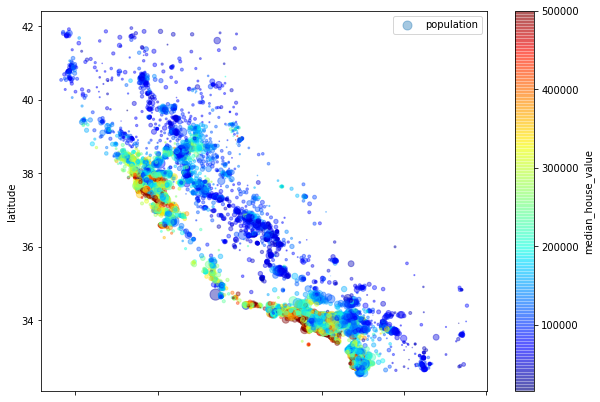

In [24]:
cal_housing_data.plot(kind="scatter", x="longitude", y="latitude", alpha = 0.4,
                      s=cal_housing_data["population"]/100, label = "population", figsize=(10,7), # s: 구역의 인구, c: 색상은 가격
                      c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True,
                      )
plt.legend()

### 상관관계 조사  
  
모든 특성 간의 표준 상관계수 standard correlation coefficient (피어슨의 r)을 corr() 메서드를 이용해 쉽게 계산할 수 있다. 
  



In [90]:
corr_matrix = cal_housing_data.corr()

In [91]:
corr_matrix["median_house_value"] # range: -1,1

longitude            -0.045837
latitude             -0.144289
housing_median_age    0.105536
total_rooms           0.134253
total_bedrooms        0.050701
population           -0.024552
households            0.065952
median_income         0.688000
median_house_value    1.000000
Name: median_house_value, dtype: float64

위 카테고리 간의 상관 계수를 보면, 중간 주택 가격과 중간 수입 간의 상대적으로 강한 상관 관계를 볼 수 있다. 이는 주간 수입이 증가하면 중간 주택 가격이 증가한다는 것을 함의한다. 반면에, 계수가 0에 가까우면 선형적 상관 관계가 없음을 의미한다.

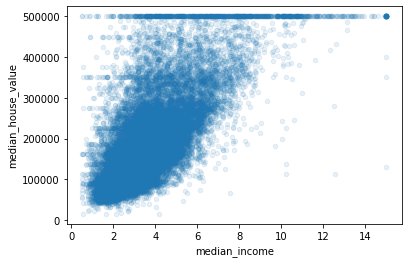

In [92]:
cal_housing_data.plot(kind="scatter",
                      x="median_income",
                      y="median_house_value",
                      alpha=0.1)


위 그래프를 통해 우리는 (1) 양 카테고리 간의 상관 관계가  강하다는 것을 알 수 있고 -- 위쪽으로 향함, 포인트들이 서로 가까워 --, (2) 가격 제한값이 50만 달러라는 것을 알 수 있다.

### 특성 간의 상관관계 만들기

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7796877898>,
      dtype=object)

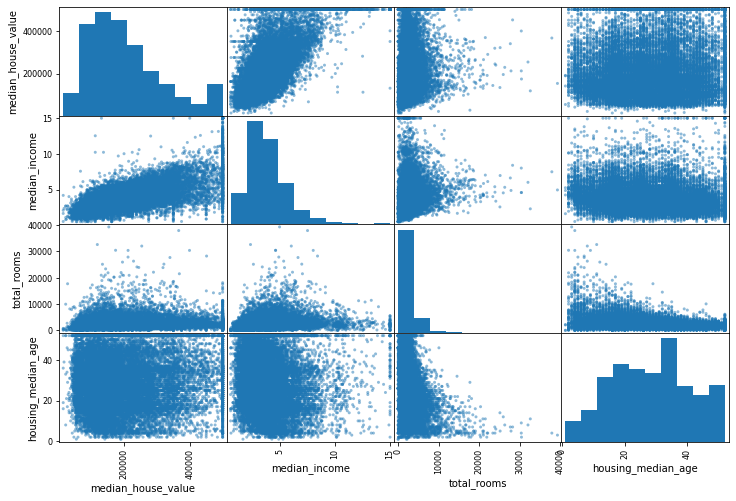

In [97]:
from pandas.plotting import scatter_matrix

attributes=["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(cal_housing_data[attributes],figsize=(12,8))

#### 특정 특성에 초점맞추기  


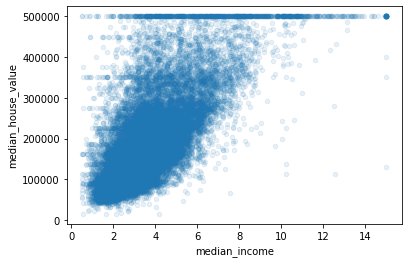

In [99]:
cal_housing_data.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

위 그래프로부터 알 수 있는 사실:  
  
- (1) 상관관계가 강하다 [위쪽으로 향하는 경향이 있고, 포인트들이 모여있다] 
- (2) 가격 제한값 50만 달러가 수평선으로 잘 보인다  


### 새로운 특성 만들기  
  


In [93]:
cal_housing_data["bedrooms_per_room"] = cal_housing_data["total_bedrooms"]/cal_housing_data["total_rooms"]

다시 상관 관계 조사

In [94]:
corr_matrix = cal_housing_data.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688000
total_rooms           0.134253
housing_median_age    0.105536
households            0.065952
total_bedrooms        0.050701
population           -0.024552
longitude            -0.045837
latitude             -0.144289
bedrooms_per_room    -0.255542
Name: median_house_value, dtype: float64

위 데이터 분석을 통해 우리는 -- bedrooms_per_room의 값이 0에서 더 멀기 때문에 -- 총 방의 개수, 침실의 개수 보다 중간 가격과 더 높은 상관 관계를 가진다는 것을 알 수 있다. 그러면 이 새롭게 만들어진 특성은 우리가 주택 가격 예측을 함에 있어서 유의미한 특성이라고 간주될 수 있다.

# 2.5 ML 알고리즘을 위한 데이터 준비  
  


## 1.데이터 복사본 만들기

In [100]:
cal_housing_data = strat_train_set.drop("median_house_value",axis=1)
cal_housing_labels = strat_train_set["median_house_value"].copy()

## 2.데이터 정제

ML 알고리즘 대다수는 **누락된_특성을_다루지_못한**다. 지금부터 이것을 처리할 수 있는 함수를 따로 알아보자. 방법은 3 가지이다:  
  
- 해당 구역 제거  
- 전체 특성 삭제  
- 어떤 값(0, 평균 등)으로 채운다

In [103]:
cal_housing_data.dropna(subset=["total_bedrooms"]) #옵션 1
cal_housing_data.drop("total_bedrooms",axis=1) # 옵션 2
median = cal_housing_data["total_bedrooms"].median() #옵션 3 중간값을 누락된 곳에 넣어줘

cal_housing_data["total_bedrooms"].fillna(median, inplace=True)

아래 임포트로 누락된 값을 쉽게 다룰 수 있다.

In [104]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

중간값은 **수치형_특성**에서만 계산되니까 텍스트 특성인 ocean_proximity를 제외하자.

In [106]:
imputer.fit(cal_housing_data)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [107]:
imputer.statistics_

array([-118.49  ,   34.26  ,   29.    , 2134.    ,  436.    , 1170.    ,
        410.    ,    3.5417])

In [108]:
cal_housing_data.median().values

array([-118.49  ,   34.26  ,   29.    , 2134.    ,  436.    , 1170.    ,
        410.    ,    3.5417])

이제 학습된 Imputer 객체를 사용하여 훈련셋에서 누락된 값을 학습한 중간값으로 바꿀 수 있다:

In [110]:
X = imputer.transform(cal_housing_data)

In [112]:
housing_tr = pd.DataFrame(X, columns = cal_housing_data.columns, index= cal_housing_data.index)
print(housing_tr)

       longitude  latitude  ...  households  median_income
4675     -118.34     34.07  ...       297.0         5.8632
19545    -121.00     37.63  ...        66.0         1.7500
19863    -119.37     36.35  ...       178.0         5.3767
6339     -117.90     33.98  ...      2159.0         3.2530
15491    -117.21     33.13  ...       554.0         3.7750
...          ...       ...  ...         ...            ...
20473    -118.75     34.26  ...       250.0         5.4787
13974    -116.76     34.23  ...       376.0         2.6071
8906     -118.47     34.03  ...       823.0         3.7381
16804    -122.41     37.66  ...       353.0         4.4750
15083    -116.96     32.80  ...       742.0         3.3690

[16511 rows x 8 columns]


## 3.텍스트와 범주형 특성 다루기  
  


### 3.1 범주형 특성 다루기

내가 직접 만든 자신만의 변환기가 필요할 수 있다. 사이킷런은 Duck Typing --- [상속이나 인터페이스 구현이 아닌, 객체의 속성이나 메서드가 객체의 유형을 결정하는 방식] --- 을 지원하므로, fit(), transform() 등을 구현한 파이썬 클래스를 만들면 된다.